# GPy

This paper http://www.auai.org/uai2013/prints/papers/244.pdf proposed the estimation of Gaussian Processes using variational inference enabling the usage of Gaussian Processes for big data as we do not use the closed form solutions for the predicted surface and the variances, which are $$\mathcal{O}(n^3)$$ in terms of computational complexity and $$\mathcal{O}(n^2)$$ in terms of storage. This allows us to potentially use all of the data and refrain from large subsampling.

In [ ]:
# Update und install
conda update scipy
conda update -n base -c defaults conda
pip install gpy

In [1]:
import pandas as pd
import numpy as np
import os
import GPy

In [2]:
os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")

In [13]:
# Not detrended, just as proof of concept
df = pd.read_csv("data_cleaned_final.csv")
df_subsampled = df.sample(frac=0.1)
df_subsampled["lat"] = df_subsampled["lat"].astype(np.uint8)
df_subsampled["lon"] = df_subsampled["lon"].astype(np.uint8)
df_subsampled["pm25"] = df_subsampled["pm25"].astype(np.uint8)

X = df_subsampled[["lat", "lon"]].to_numpy()
Y = df_subsampled[["pm25"]].to_numpy()

In [ ]:
# Model
fit = GPy.models.GPRegression(X, Y)
fit.optimize()

# GPFlow

Great package to fit Gaussian processes with the inducing points method implemented, which should be great for us. Remember that we can build confidence intervals for both $\hat{f}$ and $Y$ (confidence vs. prediction intervals). We are interested in intervals for $\hat{f}$.

In [1]:
pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0

     -------------------------------------- 373.0/373.0 kB 7.7 MB/s eta 0:00:00
     ------------------------------------- 455.9/455.9 MB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 52.7 MB/s eta 0:00:00
     ---------------------------------------- 45.6/45.6 kB ? eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ---------------------------------------- 126.5/126.5 kB ? eta 0:00:00
     ------------------------------------- 895.9/895.9 kB 59.0 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 1.7/1.7 MB 54.0 MB/s eta 0:00:00
     --------------------------------------- 24.4/24.4 MB 43.7 MB/s eta 0:00:00
     ---------------------------------------- 4.0/4.0 MB 50.6 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 5.9/5.9 MB 53.3 MB/s

In [14]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow

from scipy.cluster.vq import kmeans

from sklearn.metrics import mean_squared_error

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

### 0.1 Auxiliary Functions

In [6]:
def plot_2d_model(model: gpflow.models.GPModel) -> None:
    n_grid = 50
    _, (ax_mean, ax_std) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    Xplots = np.linspace(0.0, 1.0, n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])

    iv = getattr(model, "inducing_variable", None)
    # Do not optimize inducing variables, so that we can better see the impact their choice has. When solving
    # a real problem you should generally optimise your inducing points.
    if iv is not None:
        gpflow.set_trainable(iv, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    y_mean, y_var = model.predict_y(Xplot)
    y_mean = y_mean.numpy()
    y_std = tf.sqrt(y_var).numpy()

    ax_mean.pcolor(Xplot1, Xplot2, y_mean.reshape(Xplot1.shape))
    ax_std.pcolor(Xplot1, Xplot2, y_std.reshape(Xplot1.shape))
    ax_mean.scatter(X[:, 0], X[:, 1], s=50, c="black")
    ax_std.scatter(X[:, 0], X[:, 1], s=50, c="black")

    # Also plot the inducing variables if possible:
    if iv is not None:
        ax_mean.scatter(iv.Z[:, 0], iv.Z[:, 1], marker="x", color="red")

### 0.2 Fitting the model

In [4]:
# Data
df = pd.read_csv("data_cleaned_final.csv")
df_subsampled = df.sample(n = 3000)

X = df_subsampled[["lat", "lon"]].to_numpy()
Y = df_subsampled[["pm25_detrended_15"]].to_numpy()

array([[<AxesSubplot:title={'center':'lat'}>]], dtype=object)

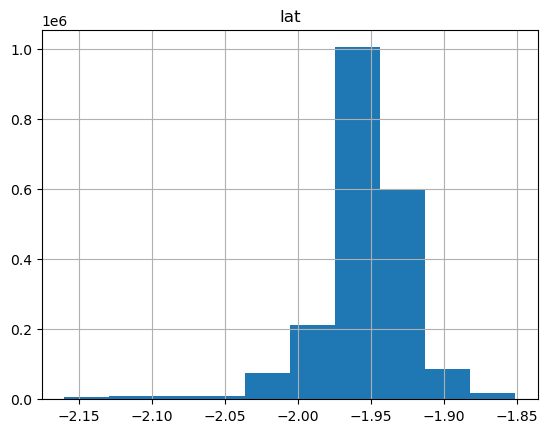

In [40]:
df.hist(column = "lat", bins = 10)

In [ ]:
# Init normal model
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
)
plot_2d_model(model)

In [10]:
# Train model
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

      fun: 6723.454134385473
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.63647858e+07, -2.11382860e+00, -2.11316081e+00])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 103
      nit: 19
     njev: 103
   status: 2
  success: False
        x: array([-26.30491496, 412.22882623, 488.2642437 ])

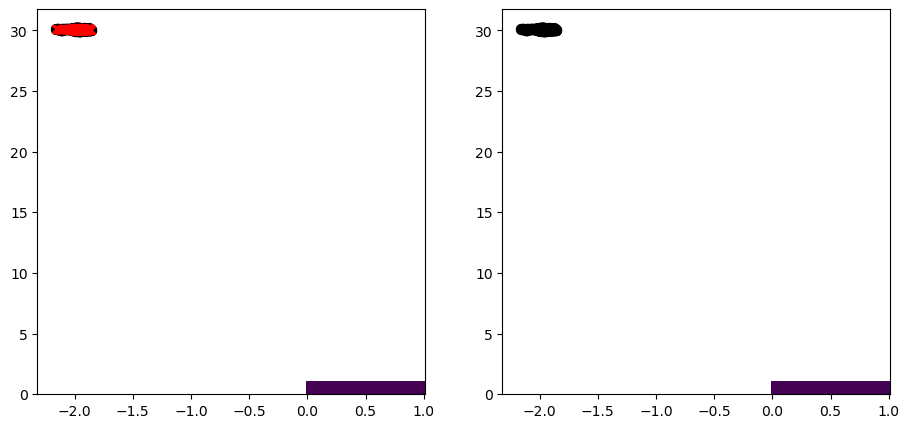

In [15]:
# Pick inducing points via k-means
n_inducing = 500
inducing_variable, _ = kmeans(X, n_inducing)

model = gpflow.models.SGPR(
    (X, Y),
    kernel=gpflow.kernels.Exponential(),
    inducing_variable=inducing_variable,
)
plot_2d_model(model)

In [8]:
# Train inducing points model
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

      fun: 18407.990032610523
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0000000e+00,  0.0000000e+00, -1.7423444e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ -318.43971623, -1020.98007571, 12507.88889364])

In [43]:
# See parameters
model

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,4599.45406
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(498, 2)",float64,"[[-1.94089, 30.06063..."


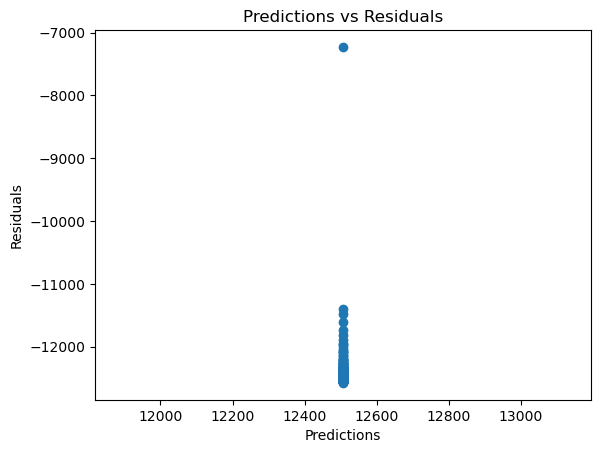

MSE: 156143445.94971666


In [22]:
# Compute predictions, residuals and plot them
model.predict_f(X)[1]
residuals = Y - model.predict_y(X)[1]

# Plot the predictions vs residuals
plt.scatter(model.predict_y(X)[1], residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Predictions vs Residuals')
plt.show()

# Compute the MSE
mse = mean_squared_error(Y, model.predict_y(X)[1])
print('MSE:', mse)

In [21]:
model.predict_y(X)[1]

<tf.Tensor: shape=(3000, 1), dtype=float64, numpy=
array([[12507.13789483],
       [12507.13789483],
       [12507.13789483],
       ...,
       [12507.13789483],
       [12507.13789483],
       [12507.13789483]])>

# PYMC - Learn

In [11]:
# Install the package
!pip install git+https://github.com/pymc-devs/pymc4@1c5e23825271fc2ff0c701b9224573212f56a534

  Running command git clone --filter=blob:none --quiet https://github.com/pymc-devs/pymc4 'C:\Users\eminu\AppData\Local\Temp\pip-req-build-j1bc1697'
  Running command git rev-parse -q --verify 'sha^1c5e23825271fc2ff0c701b9224573212f56a534'
  Running command git fetch -q https://github.com/pymc-devs/pymc4 1c5e23825271fc2ff0c701b9224573212f56a534
  Running command git checkout -q 1c5e23825271fc2ff0c701b9224573212f56a534
ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\eminu\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Cloning https://github.com/pymc-devs/pymc4 (to revision 1c5e23825271fc2ff0c701b9224573212f56a534) to c:\users\eminu\appdata\local\temp\pip-req-build-j1bc1697
  Resolved https://github.com/pymc-devs/pymc4 to commit 1c5e23825271fc2ff0c701b9224573212f56a534
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 6.9/6.9 MB 22.0 MB/s eta 0:00:00
     ------------------------------------- 869.5/869.5 kB 26.9 MB/s eta 0:00:00
     ------------------------------------- 178.5/178.5 MB 13.1 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 39.4 MB/s eta 0:00:00
     ------------------------------------- 420.6/420.6 kB 25.7 MB/s eta 0:00:00
     ---------

In [13]:
# Load
import logging
import pymc as pm
import numpy as np
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

%matplotlib inline

print(pm.__version__)
print(tf.__version__)
print(tfp.__version__)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [ ]:
conda activate pymc_env